# Linear PV Estimator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from post_process import plotter

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/tylor/dev/oedisi_dopf/scenario/
0 omoo_medium_extreme
1 small_extreme
2 medium_extreme
3 omoo_small
4 small
5 omoo_medium
6 ekf_ieee123
7 omoo
8 medium_medium
9 large
10 medium_high
11 ieee123
12 medium_low
13 small_medium
14 small_low
15 lest_small
16 medium
17 small_high
18 lest_ieee123
19 lest_test


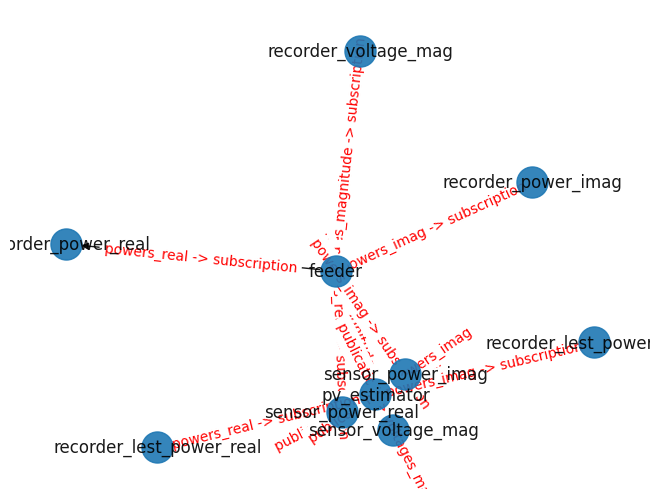

In [2]:
index = 18
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)

In [3]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}") 

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenario/lest_ieee123/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenario/lest_ieee123/system.json
Building system in build_lest_ieee123


0

In [4]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: lest_ieee123
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_mag as a background process
[info] Running federate recorder_lest_power_real as a background process
[info] Running federate recorder_lest_power_imag as a background process
[info] Running federate feeder as a background process
[info] Running federate sensor_voltage_mag as a background process
[info] Running federate sensor_power_real as a background process
[info] Running federate sensor_power_imag as a background process
[info] Running federate pv_estimator as a background process
[info] Running federate broker as a background process
[info] Waiting for 11 proces

0

In [83]:
# Directory location
directory = f"{OUTPUTS}/{SCENARIO}"
power_real = os.path.join(directory, "power_real.feather")
power_imag = os.path.join(directory, "power_imag.feather")
power_real_est = os.path.join(directory, "lest_power_real.feather")
power_imag_est = os.path.join(directory, "lest_power_imag.feather")
time = ["12:00"]

from math import sqrt, floor
import pandas as pd
from datetime import datetime
import pyarrow.feather as feather
from matplotlib import colormaps

In [85]:
def get_time(x):
    return datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S'
        ).time().strftime("%H:%M")
    
df_act = pd.read_feather(power_real)
df_act = df_act.drop(columns='time')

df_act = df_act[df_act.lt(0)].dropna(axis=1)

df_act_a = df_act.filter(like='.1')
df_act_b = df_act.filter(like='.2')
df_act_c = df_act.filter(like='.3')

df_est = pd.read_feather(power_real_est)
df_est = df_est.drop(columns='time')
df_est = df_est[df_est.lt(0)].dropna(axis=1)

df_est_a = df_est.filter(like='.1')
df_est_b = df_est.filter(like='.2')
df_est_c = df_est.filter(like='.3')

df_est_a_true = df_est_a.filter(items=df_act_a.columns)
cm = colormaps['tab20'].colors
idx = ['true', 'est']

<Axes: >

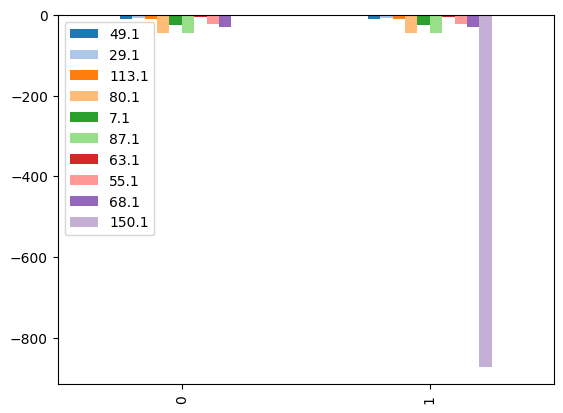

In [78]:
df = pd.concat([df_est_a, df_act_a], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)

<Axes: >

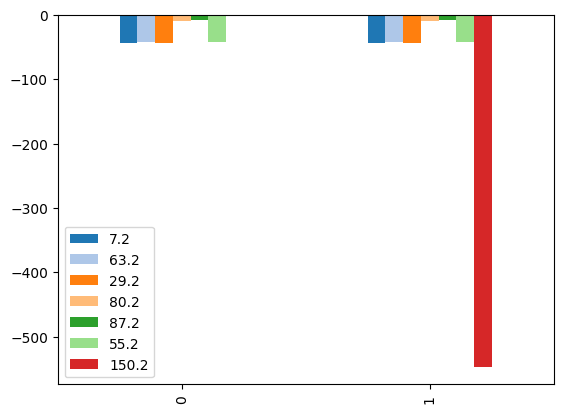

In [76]:
df = pd.concat([df_est_b, df_act_b], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)

<Axes: >

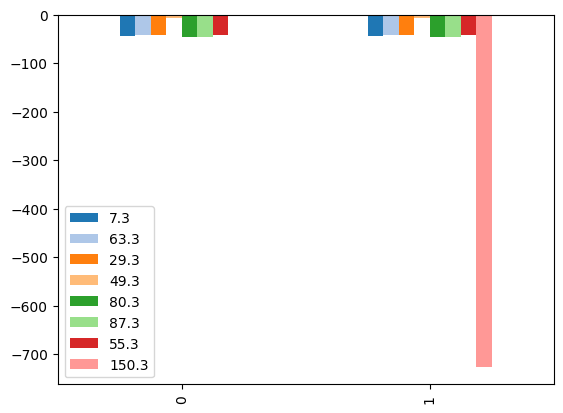

In [77]:
df = pd.concat([df_est_c, df_act_c], ignore_index=True).fillna(0)
fig, ax = plt.subplots()
df.plot.bar(color=cm, ax=ax)